# 01. Exploración Inicial de Datos (EDA)

**Objetivo:** Comprender la naturaleza de los datos inmobiliarios desde la tabla `input_data` de nuestra base de datos SQLite. Identificaremos problemas de calidad, analizaremos distribuciones y buscaremos patrones iniciales.

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
from pathlib import Path
import plotly.express as px

# --- Configuración Visual ---
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

# --- Configuración del Path del Proyecto ---
current_dir = Path(os.getcwd())
project_root = current_dir.parent
sys.path.append(str(project_root))

# --- Import de métodos para menejo de la db ---
from src.database import DatabaseManager

## 1. Carga de Datos desde SQLite
Usamos nuestro `DatabaseManager` para extraer los datos de la tabla `input_data`.

In [14]:
try:
    # Instanciamos el manager que maneja la conexión a SQLite automáticamente
    db = DatabaseManager()
    
    print("⏳ Cargando datos desde la tabla 'input_data'...")
    # Usamos el método get_inpot_data para obtener la info de la db.
    df = db.get_input_data()
    
    if not df.empty:
        print(f"Datos cargados exitosamente: {df.shape[0]} filas, {df.shape[1]} columnas")
    else:
        print("La tabla 'input_data' parece estar vacía. ¿Ejecutaste el pipeline de ingesta?")

except Exception as e:
    print(f"Error al conectar con la base de datos: {e}")
    # Crear DF vacío para evitar errores en celdas siguientes si falla la carga
    df = pd.DataFrame()

⏳ Cargando datos desde la tabla 'input_data'...
Datos cargados exitosamente: 359423 filas, 13 columnas


In [15]:
# Inspección inicial
if not df.empty:
    display(df.head())
    print("-" * 80)
    df.info()
else:
    print("No hay datos para mostrar.")

,id,property_id,property_type,operation_type,location,surface_total,surface_covered,rooms,bedrooms,bathrooms,price_usd,created_at,raw_data
0,1,192912,Departamento,Venta,,77.0,67.0,3.0,2.0,2.0,235500.0,2025-11-04 16:42:42.622980,"{'id': 192912, 'ad_type': 'Propiedad', 'start_..."
1,2,238224,Departamento,Venta,,60.0,55.0,2.0,NaN,1.0,175000.0,2025-11-04 16:42:42.951105,"{'id': 238224, 'ad_type': 'Propiedad', 'start_..."
2,3,257134,Ph,Venta,,74.0,47.0,2.0,1.0,1.0,140000.0,2025-11-04 16:42:42.966711,"{'id': 257134, 'ad_type': 'Propiedad', 'start_..."
3,4,521738,Departamento,Venta,,66.0,64.0,3.0,2.0,1.0,173000.0,2025-11-04 16:42:42.966711,"{'id': 521738, 'ad_type': 'Propiedad', 'start_..."
4,5,383947,Ph,Venta,,55.0,55.0,3.0,2.0,1.0,155000.0,2025-11-04 16:42:42.966711,"{'id': 383947, 'ad_type': 'Propiedad', 'start_..."


--------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359423 entries, 0 to 359422
Data columns (total 13 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   id               359423 non-null  int64         
 1   property_id      359423 non-null  object        
 2   property_type    359423 non-null  object        
 3   operation_type   359423 non-null  object        
 4   location         359423 non-null  object        
 5   surface_total    359423 non-null  float64       
 6   surface_covered  314565 non-null  float64       
 7   rooms            254488 non-null  float64       
 8   bedrooms         187311 non-null  float64       
 9   bathrooms        305440 non-null  float64       
 10  price_usd        359423 non-null  float64       
 11  created_at       359423 non-null  datetime64[ns]
 12  raw_data         359423 non-null  object       

## 2. Análisis de Calidad de Datos
Revisamos valores nulos y tipos de datos extraños.

C:\Users\damianc\AppData\Local\Temp\ipykernel_3932\506926889.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=missing.values, y=missing.index, palette="viridis")


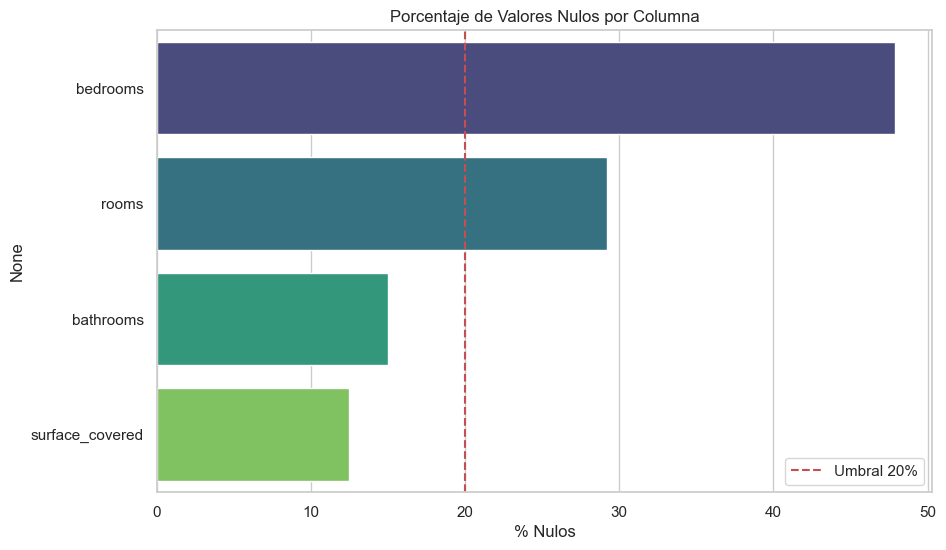

In [16]:
if not df.empty:
    # Porcentaje de nulos
    missing = df.isnull().sum() / len(df) * 100
    missing = missing[missing > 0].sort_values(ascending=False)

    if not missing.empty:
        plt.figure(figsize=(10, 6))
        sns.barplot(x=missing.values, y=missing.index, palette="viridis")
        plt.title("Porcentaje de Valores Nulos por Columna")
        plt.xlabel("% Nulos")
        plt.axvline(x=20, color='r', linestyle='--', label='Umbral 20%')
        plt.legend()
        plt.show()
    else:
        print("No hay valores nulos en el dataset.")
else:
    print("Saltando análisis (sin datos).")

## 3. Distribución del Target (`price_usd`)
Es fundamental entender cómo se comporta nuestra variable objetivo.

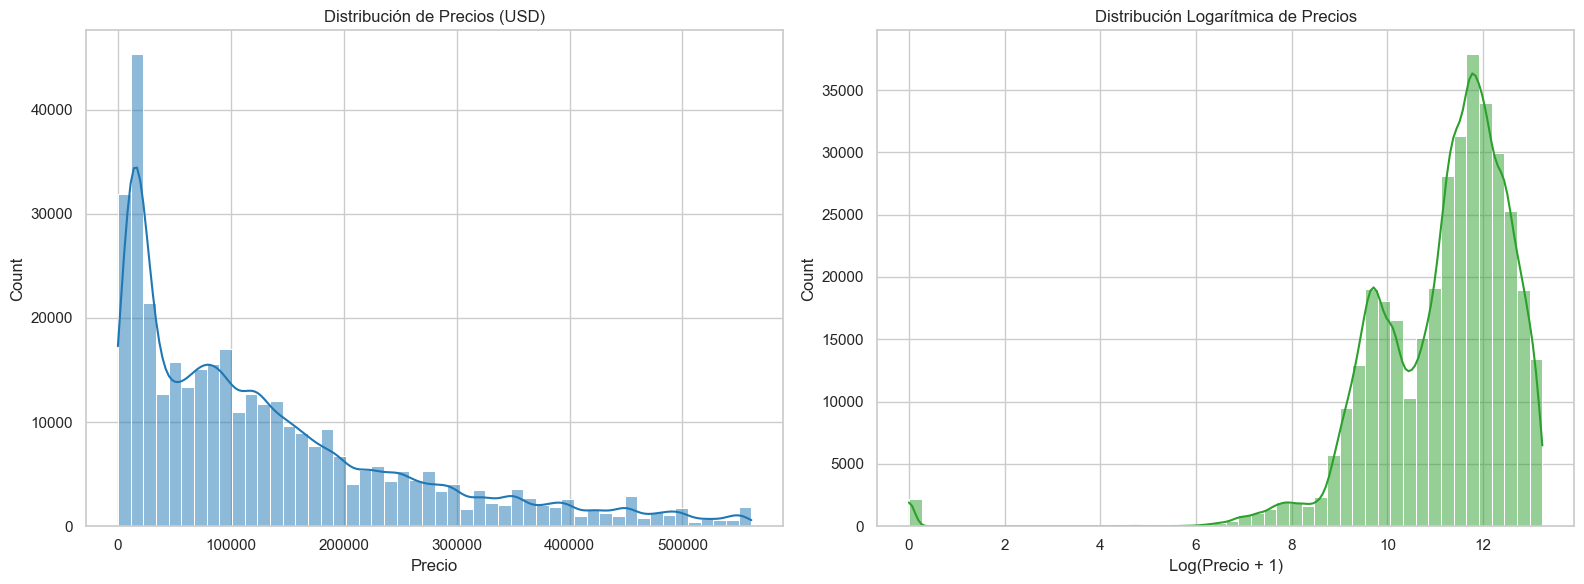

Estadísticos de Precio:


count    359,423.00
mean     131,689.20
std      124,999.35
min            0.00
25%       28,000.00
50%       95,000.00
75%      190,000.00
max      561,000.00
Name: price_usd, dtype: object

In [17]:
if not df.empty and 'price_usd' in df.columns:
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # 1. Escala Normal
    sns.histplot(df['price_usd'].dropna(), bins=50, kde=True, ax=axes[0], color='#1f77b4')
    axes[0].set_title('Distribución de Precios (USD)')
    axes[0].set_xlabel('Precio')
    
    # 2. Escala Logarítmica (ayuda a ver mejor datos sesgados como precios)
    sns.histplot(np.log1p(df['price_usd'].dropna()), bins=50, kde=True, ax=axes[1], color='#2ca02c')
    axes[1].set_title('Distribución Logarítmica de Precios')
    axes[1].set_xlabel('Log(Precio + 1)')

    plt.tight_layout()
    plt.show()

    print("Estadísticos de Precio:")
    display(df['price_usd'].describe().apply("{0:,.2f}".format))
else:
    print("Columna 'price_usd' no encontrada o sin datos.")

## 4. Análisis Bivariado: Relaciones Clave
Exploramos cómo las características físicas influyen en el precio.

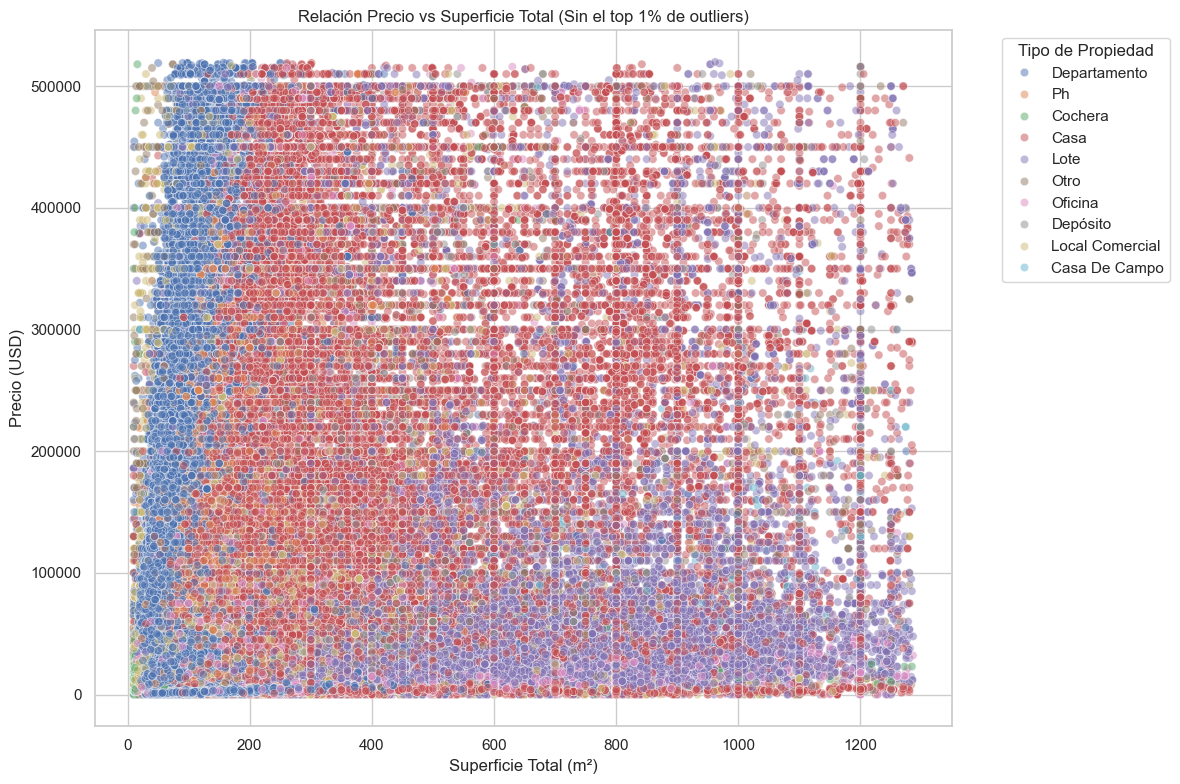

In [ ]:
if not df.empty and 'surface_total' in df.columns and 'price_usd' in df.columns:
    # Filtros para visualización (quitamos outliers extremos solo para el gráfico)
    mask = (df['surface_total'] < df['surface_total'].quantile(0.99)) & \
           (df['price_usd'] < df['price_usd'].quantile(0.99))
    
    plot_df = df[mask]

    plt.figure(figsize=(12, 8))
    sns.scatterplot(
        data=plot_df, 
        x='surface_total', 
        y='price_usd', 
        hue='property_type', #colorea por tipo
        alpha=0.5,
        palette='deep'
    )
    plt.title('Relación Precio vs Superficie Total (Sin el top 1% de outliers)')
    plt.xlabel('Superficie Total (m²)')
    plt.ylabel('Precio (USD)')
    plt.legend(title='Tipo de Propiedad', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
else:
    print("Faltan columnas necesarias para este gráfico.")

## 5. Matriz de Correlación
¿Qué variables numéricas están más relacionadas entre sí?

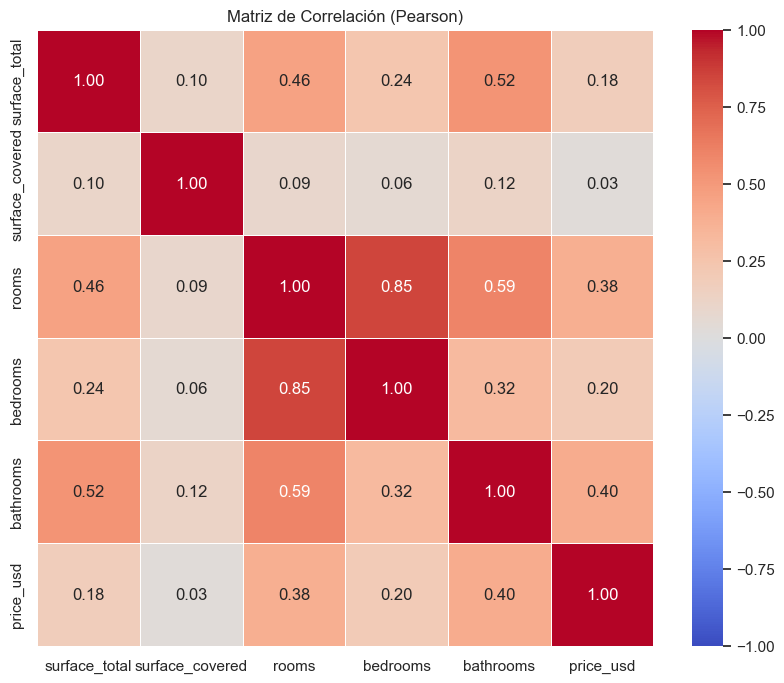

In [11]:
if not df.empty:
    # Seleccionamos solo columnas numéricas
    numeric_df = df.select_dtypes(include=[np.number])
    
    # Quitamos columnas que no son features reales (como IDs)
    cols_to_drop = ['id'] # 'id' es la primary key de SQLite
    numeric_df = numeric_df.drop(columns=[c for c in cols_to_drop if c in numeric_df.columns])

    if numeric_df.shape[1] > 1:
        plt.figure(figsize=(10, 8))
        # Usamos método spearman si sospechamos relaciones no lineales o muchos outliers
        corr = numeric_df.corr(method='pearson') 
        
        sns.heatmap(
            corr, 
            annot=True, 
            fmt=".2f", 
            cmap='coolwarm', 
            vmin=-1, vmax=1, 
            center=0,
            square=True,
            linewidths=.5
        )
        plt.title("Matriz de Correlación (Pearson)")
        plt.show()
    else:
        print("No hay suficientes columnas numéricas para correlacionar.")